In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import collections
from scipy.spatial import ConvexHull
from scripts.plot import plot_from_files

def counts(data):
    return sorted(collections.Counter(data).items())

def head_and_tail(xs, n=5):
    if len(xs) <= 2*n:
        return xs
    return xs[:n] + ["..."] + xs[-n:]

def df_show_all_rows(df):
    with pd.option_context('display.max_rows', None):
        display(df)

In [2]:
def load_stats(path):
    return pd.read_table(path, names=['k', 'n', 'c', 'min', 'max', 'star'], sep=' ')

def load_k(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2', 'b3', 'b4', 'b5'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=[
            'n',
            'a',
            'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
            'c1', 'c2', 'c3',
            'd1', 'd2', 'd3',
            'e1', 'e2'
        ], sep=' ')
    if k == 7:
        return pd.read_table(path, names=[
            'n',
            'a',
            'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
            'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
            'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7',
            'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7',
            'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
        ], sep=' ')
    raise NotImplementedError

def load_sym_sums(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=['n', 'a', 'b', 'c', 'd', 'e'], sep=' ')
    if k == 7:
        return pd.read_table(path, names=['n', 'a', 'b', 'c', 'd', 'e', 'f'], sep=' ')
    raise NotImplementedError

In [3]:
def remove_float_xticks():
    filtered = [t for t in plt.xticks()[0] if math.isclose(t, round(t))]
    plt.xticks(np.array(filtered))

def plot_stats_histograms(df, v):
    df_v = df[df.k + df.n == v]
    min_k, max_k = df_v.k.min(), df_v.k.max()
    for k in range(3, 6):
        fig = plt.figure(figsize=(12, 2))
        # fig.suptitle('n+k = {}, k = {}'.format(v, k))
        fig.tight_layout()
        attrs = [
            # ('c', 'number of coefficients'),
            ('star', 'star coefficient value (n+k = {}, k = {})'.format(v, k)),
        ]
        for attr_i, (attr, title) in enumerate(attrs):
            df_selected = df_v[df_v.k == k][attr]
            min_, max_ = df_selected.min(), df_selected.max()
            plt.subplot(1, 1, attr_i + 1)
            plt.title(title)
            df_selected.plot.hist(bins=np.arange(min_, max_ + 2)-0.5, logy=True, ylim=(1e-1, 1e8))
            plt.yticks(10 ** np.arange(0, 8))
            plt.grid(axis='y')
            remove_float_xticks()
        plt.savefig('/home/david/Documents/fmfi/09/ds3/predobhajoba/images/star-histogram-k{}.png'.format(k), bbox_inches='tight', dpi=600)
        plt.show()
        print('star coefficient value counts:', *head_and_tail(counts(df_v[df_v.k == k].star)))
        print('----------')


# Flow Polynomial Coeffcients (Bridges Allowed)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

In [4]:
df_stats_c2m2dP = load_stats('computed/each-stats-c2m2dP-26-1.txt.gz')


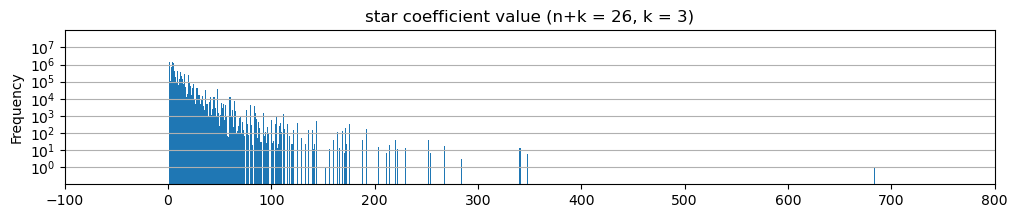

star coefficient value counts: (1, 1402804) (2, 115405) (3, 712684) (4, 1339944) (5, 1162075) ... (284, 3) (340, 14) (341, 13) (348, 6) (684, 1)
----------


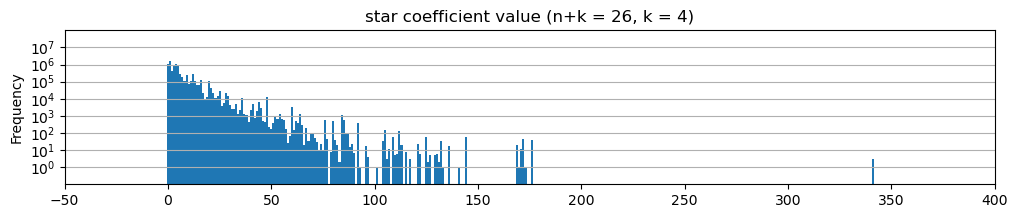

star coefficient value counts: (0, 1103696) (1, 1676633) (2, 441356) (3, 798345) (4, 1063717) ... (171, 12) (172, 46) (173, 1) (176, 38) (341, 3)
----------


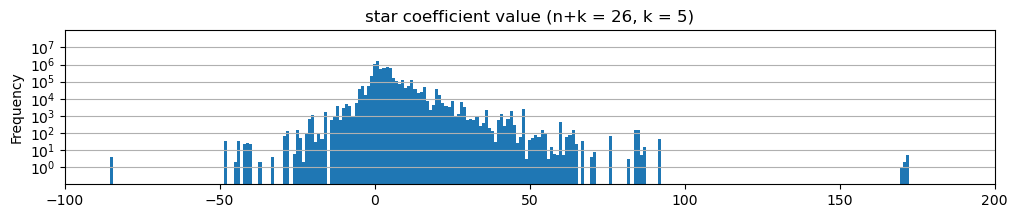

star coefficient value counts: (-85, 4) (-48, 36) (-45, 2) (-44, 35) (-42, 23) ... (87, 16) (92, 45) (170, 1) (171, 2) (172, 5)
----------


In [5]:
plot_stats_histograms(df_stats_c2m2dP, 26)


# Flow Polynomial Coeffcients (Bridges Forbidden)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

In [6]:
df_stats_dP = load_stats('computed/each-stats-dP-26-1.txt.gz')


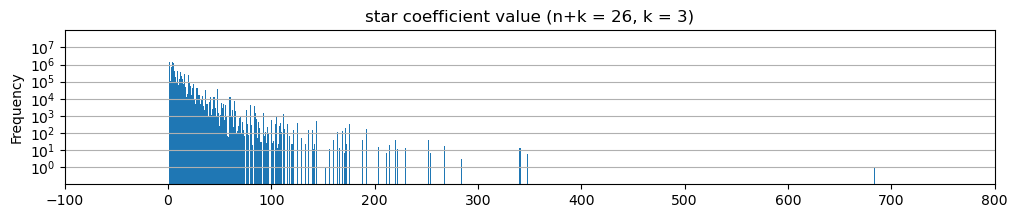

star coefficient value counts: (1, 1402804) (2, 115405) (3, 712684) (4, 1339944) (5, 1162075) ... (284, 3) (340, 14) (341, 13) (348, 6) (684, 1)
----------


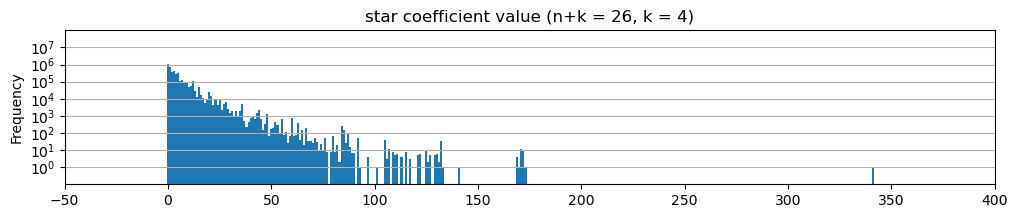

star coefficient value counts: (0, 1103696) (1, 668197) (2, 388633) (3, 434960) (4, 274631) ... (170, 1) (171, 12) (172, 9) (173, 1) (341, 1)
----------


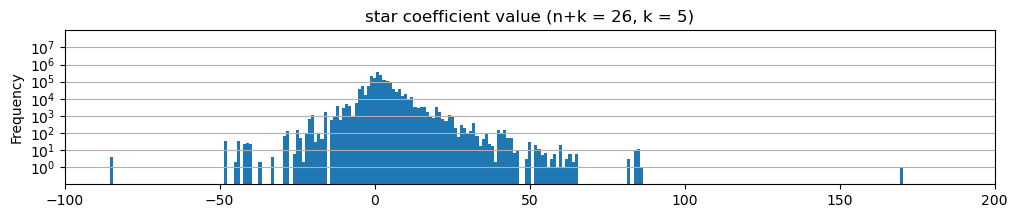

star coefficient value counts: (-85, 4) (-48, 36) (-45, 2) (-44, 35) (-42, 23) ... (82, 3) (84, 9) (85, 11) (86, 1) (170, 1)
----------


In [7]:
plot_stats_histograms(df_stats_dP, 26)


# The Bridgeless 3-pole, 4-pole, and 5-pole With the Largest Star Coefficient Value

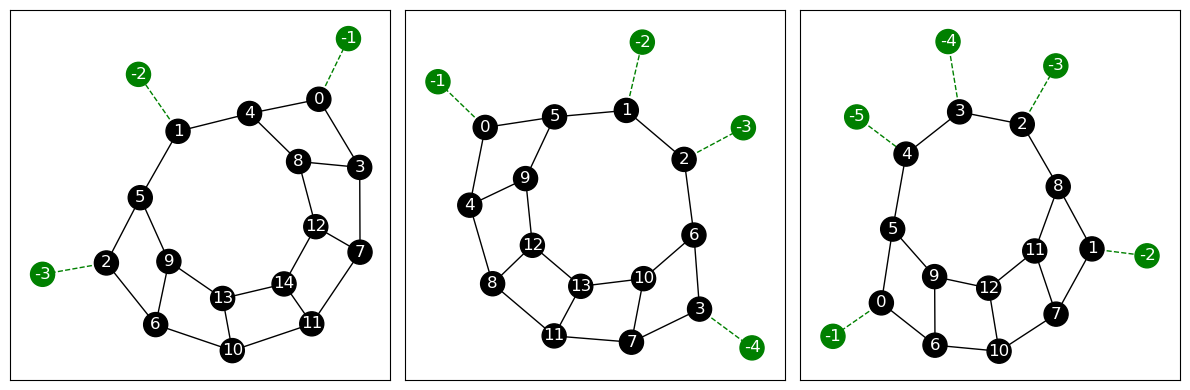

In [8]:
plot_from_files([
    'graphs/max_star/3-18.txt',
    'graphs/max_star/4-18.txt',
    'graphs/max_star/5-18.txt',
])


---

In [9]:
def plot_k4(df, v):
    df_v = df[4 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2']).size().reset_index(name='cnt')
    df_agg['colorings'] = 21*df_agg.a + 9*(df_agg.b1 + df_agg.b2)

    a, b1, b2 = df_agg.a, df_agg.b1, df_agg.b2

    assert (a >= 0).all()
    assert (a + b1 >= 0).all()
    assert (a + b2 >= 0).all()
    assert (a + b1 + b2 >= 0).all()

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('n+k = {}, k = 4'.format(v))

    # xs, ys, zs = a, b1, b2
    # ax = fig.add_subplot(121, projection='3d')
    # ax.set_xlabel('star value')
    # ax.set_ylabel('second value')
    # ax.set_zlabel('third value')
    # min_ = min(xs.min(), ys.min(), zs.min())-5
    # max_ = max(xs.max(), ys.max(), zs.max())+5
    # ax.set_xlim(min_, max_)
    # ax.set_ylim(min_, max_)
    # ax.set_zlim(min_, max_)
    # ax.set_aspect('equal')
    # ax.scatter(xs, ys, zs, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)
    # ax.view_init(15, -135)

    xs, ys = a, b1 + b2
    # ax = fig.add_subplot(111)
    ax = plt.gca()
    ax.set_xlabel('a')
    ax.set_ylabel('b1 + b2')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    lsp = np.linspace(min_, max_, 500)
    X, Y = np.meshgrid(lsp, lsp)
    Z = 21*X + 9*Y
    Z[(X < 0) | (X + Y < 0)] = np.nan
    ax.imshow(Z, extent=[min_, max_, min_, max_], cmap='Greens', origin='lower')
    # ax.axline((0, 0), slope=9/21, color='k', linestyle='--', linewidth=0.5)
    ax.text(max_-5, max_-5, 'color stregth = number of colorings', ha='right', va='top')

    ax.plot([0, 0.00001], [0, 100000], color='c')
    ax.plot([0, 1000], [0, -1000], color='m')

    plt.grid()
    plt.tight_layout()
    plt.savefig('/home/david/Documents/fmfi/09/ds3/predobhajoba/images/coef-scatter-k4.png', bbox_inches='tight', dpi=600)
    plt.show()

    return df_agg.sort_values(by='colorings')


# Coeffcient Values for $k=4$ (Bridges Allowed)

In [10]:
df_k4_c2m2dP4 = load_k(4, 'computed/each-k4-c2m2dP4-26-1.txt.gz')


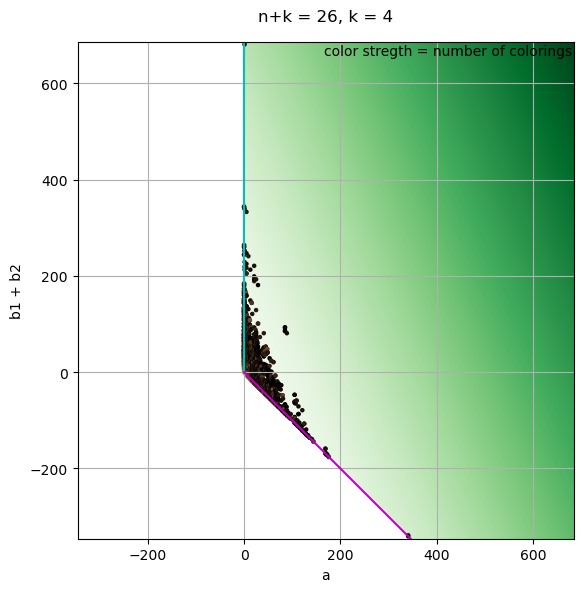

,a,b1,b2,cnt,colorings
302,1,-1,0,812857,12
307,1,0,-1,195579,12
0,0,1,1,325390,18
648,2,-2,0,39248,24
661,2,0,-2,13475,24
...,...,...,...,...,...
300,0,340,4,4,3096
1977,5,338,-5,4,3102
9228,341,0,-341,2,4092
9227,341,-341,2,1,4110


In [11]:
plot_k4(df_k4_c2m2dP4, 26)


# Coeffcient Values for $k=4$ (Bridges Forbidden)

In [12]:
df_k4_dP4 = load_k(4, 'computed/each-k4-dP4-26-1.txt.gz')


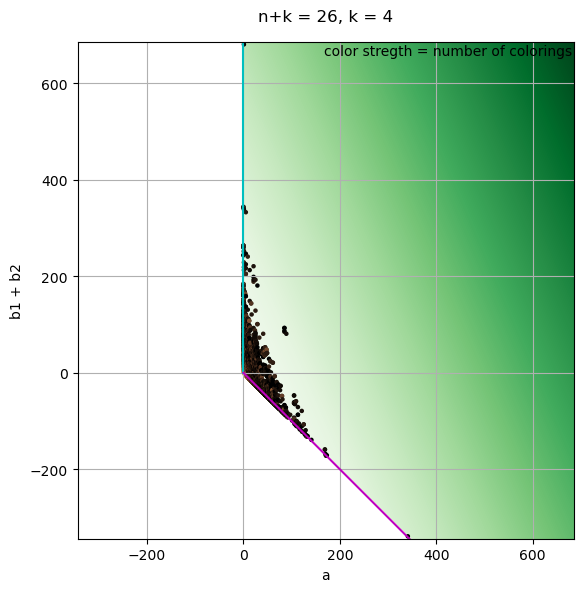

,a,b1,b2,cnt,colorings
0,0,1,1,325390,18
653,2,-1,-1,33887,24
307,1,0,1,33325,30
312,1,1,0,2555,30
319,1,2,-1,272431,30
...,...,...,...,...,...
296,0,172,172,2,3096
301,0,340,4,4,3096
1970,5,338,-5,4,3102
9065,341,-341,2,1,4110


In [13]:
plot_k4(df_k4_dP4, 26)


# The Bridgeless 4-pole With the Largest Number of Colorings

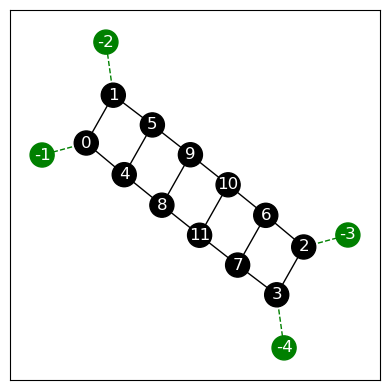

In [14]:
plot_from_files(['graphs/k4_max_colorings/16.txt'])


---

In [15]:
def plot_k5(df, v):
    df_v = df[5 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2', 'b3', 'b4', 'b5']).size().reset_index(name='cnt')
    a, b1, b2, b3, b4, b5 = df_agg.a, df_agg.b1, df_agg.b2, df_agg.b3, df_agg.b4, df_agg.b5

    for expr in [
        a + b1,   a + b1 + b2,
        a + b2,   a + b2 + b3,
        a + b3,   a + b3 + b4,
        a + b4,   a + b4 + b5,
        a + b5,   a + b5 + b1,
    ]:
        assert (expr >= 0).all()

    fig = plt.figure(figsize=(6, 6))
    fig.suptitle('n+k = {}, k = 5'.format(v))

    xs, ys = a, b1 + b2 + b3 + b4 + b5
    ax = fig.add_subplot(111)
    ax.set_xlabel('a')
    ax.set_ylabel('b1 + b2 + b3 + b4 + b5')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    lsp = np.linspace(min_, max_, 500)
    X, Y = np.meshgrid(lsp, lsp)
    Z = 60*X + 18*Y
    Z[(5*X + Y < 0) | (5*X + 2*Y < 0)] = np.nan
    ax.imshow(Z, extent=[min_, max_, min_, max_], cmap='Greens', origin='lower')
    # ax.axline((0, 0), slope=9/21, color='k', linestyle='--', linewidth=0.5)
    ax.text(max_-5, max_-5, 'color stregth = number of colorings', ha='right', va='top')

    ax.plot([0, -1000], [0, 5000], color='c')
    ax.plot([0, 1000], [0, -2500], color='m')
    ax.plot([0, 1000], [0, -2000], color='y')

    plt.grid()
    plt.tight_layout()
    plt.savefig('/home/david/Documents/fmfi/09/ds3/predobhajoba/images/coef-scatter-k5.png', bbox_inches='tight', dpi=600)
    plt.show()

    return df_agg


# Coeffcient Values for $k=5$ (Bridges Allowed)

In [16]:
df_k5_c2m2dP5 = load_k(5, 'computed/each-k5-c2m2dP5-26-1.txt.gz')


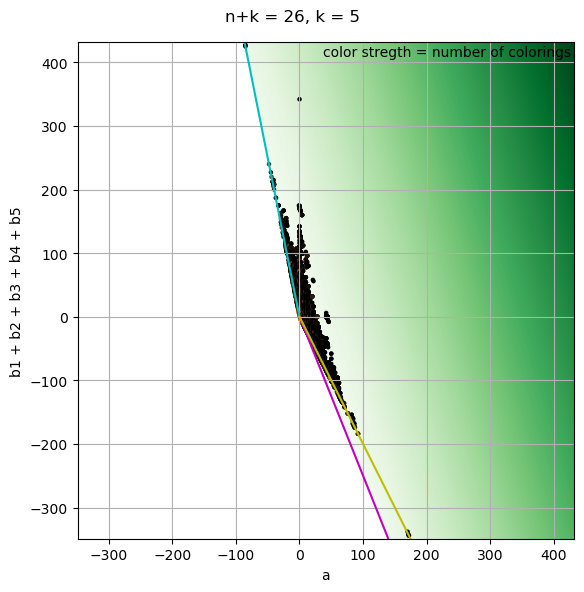

,a,b1,b2,b3,b4,b5,cnt
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
41638,170,0,-170,1,1,-170,1
41639,171,-170,0,-171,0,-1,2
41640,172,-172,0,-172,0,0,3
41641,172,-172,0,0,-172,0,1


In [17]:
plot_k5(df_k5_c2m2dP5, 26)


# Coeffcient Values for $k=5$ (Bridges Forbidden)

In [18]:
df_k5_dP5 = load_k(5, 'computed/each-k5-dP5-26-1.txt.gz')


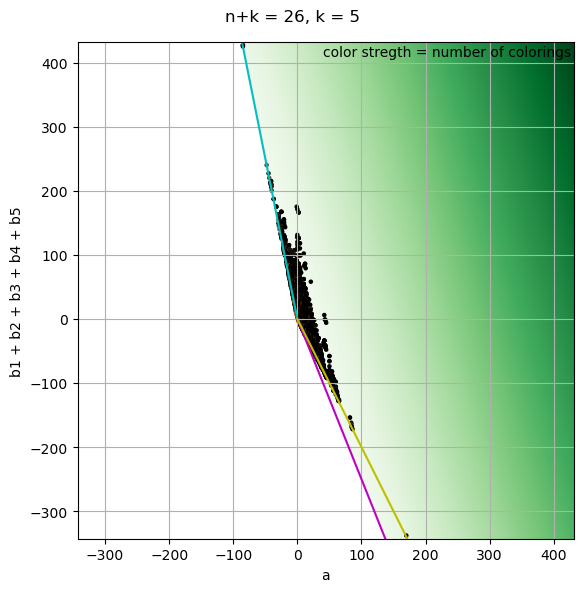

,a,b1,b2,b3,b4,b5,cnt
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
29341,85,-85,0,0,-85,1,1
29342,85,-85,1,-85,0,0,9
29343,85,-85,2,-84,-1,0,1
29344,86,0,-1,-85,-1,-85,1


In [19]:
plot_k5(df_k5_dP5, 26)


# General Constraint Analysis

In [20]:
def unique_rows(df):
    return df.drop_duplicates(ignore_index=True)

def prepare_points(k, v, flags):
    path = f'computed/unique-k{k}ss-{flags}dP{k}-{max(v, 16)}-1.txt.gz'
    df = load_sym_sums(k, path)
    df = df[k + df.n <= v]
    df = df.drop(columns='n')
    df = unique_rows(df)
    return df

def get_planes(points):
    hull = ConvexHull(points)
    planes = pd.DataFrame(hull.equations)
    planes = unique_rows(planes)
    planes.columns = points.columns.tolist() + ['offset']
    return planes

def my_isclose(a, b, rtol=1e-6, atol=1e-8):
    return np.isclose(a, b, rtol=rtol, atol=atol)

def float_to_rational(x, max_q=1000):
    assert -1 <= x <= 1 or my_isclose(abs(x), 1)
    for q in range(1, max_q+1):
        p = x*q
        if my_isclose(p, round(p)):
            return True, round(p), q
    return False, None, None

def row_to_integers(row):
    assert my_isclose(row[0], 1)
    ps, qs = [1], [1]
    for x in row[1:]:
        is_rational, p, q = float_to_rational(x)
        if not is_rational:
            return False, []
        ps.append(p)
        qs.append(q)
    common_q = math.lcm(*qs)
    return True, [int(p*(common_q//q)) for p, q in zip(ps, qs)]

def filter_integer_zero_offset_planes(planes):
    # drop planes with non-zero offset
    planes = planes[my_isclose(planes['offset'], 0)].reset_index(drop=True)
    planes = planes.drop(columns='offset')

    # scale each equation so that the first coefficient is 1
    planes = planes.apply(lambda row: row / row[0], axis=1)

    # convert each equation to integers, dropping those that don't appear to be reasonable
    filtered_rows = []
    for row in planes.values:
        is_integer, integer_row = row_to_integers(row)
        if is_integer:
            filtered_rows.append(integer_row)
    planes = pd.DataFrame(filtered_rows, columns=planes.columns)

    # sort rows primarily by a, then by sum of the other coefs, ten by the other coefs
    planes = planes.assign(sum=planes.sum(axis=1))
    planes = planes.sort_values(['a', 'sum'] + planes.columns.tolist())
    planes = planes.drop(columns='sum').reset_index(drop=True)

    # if there are duplicates by any chance, drop them
    planes = unique_rows(planes)
    return planes

def get_integer_zero_offset_planes(k, v, flags='c2m2'):
    points = prepare_points(k, v, flags)
    planes = get_planes(points)
    filtered_planes = filter_integer_zero_offset_planes(planes)
    return filtered_planes

get_integer_zero_offset_planes(4, 32)

,a,b
0,1,0
1,1,1


In [21]:
get_integer_zero_offset_planes(5, 32)

,a,b
0,2,1
1,5,1


In [22]:
get_integer_zero_offset_planes(6, 34)

,a,b,c,d,e
0,1,0,1,0,0
1,1,1,0,1,1
2,2,1,0,0,1
3,3,1,0,0,0
4,3,0,2,0,0
5,3,1,0,1,0
6,3,1,1,1,0
7,4,2,0,0,1
8,4,2,1,1,1
9,9,3,2,1,3


In [23]:
# get_integer_zero_offset_planes(7, 18)                    # 94
# get_integer_zero_offset_planes(7, 20)                    # 194
# get_integer_zero_offset_planes(7, 22)                    # 242
# get_integer_zero_offset_planes(7, 24)                    # 293
# get_integer_zero_offset_planes(7, 26)                    # 234
# get_integer_zero_offset_planes(7, 28)                    # 175
# df_show_all_rows(get_integer_zero_offset_planes(7, 30))  # 140
# df_show_all_rows(get_integer_zero_offset_planes(7, 32))  # 138
# df_show_all_rows(get_integer_zero_offset_planes(7, 34))  # 125

In [24]:
# get_integer_zero_offset_planes(7, 18)                    # 94
# get_integer_zero_offset_planes(7, 20)                    # 194
# get_integer_zero_offset_planes(7, 22)                    # 242
# get_integer_zero_offset_planes(7, 24)                    # 293
# get_integer_zero_offset_planes(7, 26)                    # 234
# get_integer_zero_offset_planes(7, 28)                    # 175
# df_show_all_rows(get_integer_zero_offset_planes(7, 30))  # 140
# df_show_all_rows(get_integer_zero_offset_planes(7, 32))  # 138
# df_show_all_rows(get_integer_zero_offset_planes(7, 34))  # 125

# The Dimension of the Flow Polynomial Space

In [25]:
for k in [4, 5, 6, 7]:
    # points = prepare_points(k, 26, '')
    points = load_k(k, f'computed/each-k{k}-dP{k}-26-1.txt.gz').drop(columns='n')
    points = unique_rows(points)
    print(np.linalg.matrix_rank(points.values), len(points.columns))

3 3
6 6
15 15
36 36


# Tightness of the Constraints Given by Minimal Color Sets

In [26]:
def mcs_k4_p1(df):
    # 1111, 1122
    df = unique_rows(df[['a', 'b1', 'b2']])
    a, b1, b2 = df.a, df.b1, df.b2
    df['colorings'] = 21*a + 9*b1 + 9*b2
    df['selected'] = 9*a + 9*b1 + 3*b2
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k4_p1(df_k4_c2m2dP4))
display(mcs_k4_p1(df_k4_dP4))

,a,b1,b2,colorings,selected,ratio
7550,176,-176,0,2112,0,0.000000
8939,172,-172,0,2064,0,0.000000
2902,169,-169,0,2028,0,0.000000
2811,144,-144,0,1728,0,0.000000
6374,136,-136,0,1632,0,0.000000
...,...,...,...,...,...,...
5725,0,254,6,2340,2304,0.984615
5210,5,338,-5,3102,3072,0.990329
8941,0,340,4,3096,3072,0.992248
1365,0,341,1,3078,3072,0.998051


,a,b1,b2,colorings,selected,ratio
8374,341,-341,2,4110,6,0.001460
8316,173,-173,2,2094,6,0.002865
2134,171,-170,-1,2052,6,0.002924
4084,141,-141,2,1710,6,0.003509
8865,133,-133,2,1614,6,0.003717
...,...,...,...,...,...,...
5592,0,254,6,2340,2304,0.984615
5083,5,338,-5,3102,3072,0.990329
8780,0,340,4,3096,3072,0.992248
1291,0,341,1,3078,3072,0.998051


In [27]:
def mcs_k4_p2(df):
    # 1212, 1221
    df = unique_rows(df[['a', 'b1', 'b2']])
    a, b1, b2 = df.a, df.b1, df.b2
    df['colorings'] = 21*a + 9*b1 + 9*b2
    df['selected'] = 12*a + 6*b1
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k4_p2(df_k4_c2m2dP4))
display(mcs_k4_p2(df_k4_dP4))

,a,b1,b2,colorings,selected,ratio
8449,1,-1,170,1542,6,0.003891
2138,0,1,85,774,6,0.007752
818,1,-1,42,390,6,0.015385
153,0,1,21,198,6,0.030303
62,1,-1,10,102,6,0.058824
...,...,...,...,...,...,...
4437,89,170,-89,2598,2088,0.803695
5213,169,10,-169,2118,2088,0.985836
7551,176,0,-176,2112,2112,1.000000
8448,341,0,-341,4092,4092,1.000000


,a,b1,b2,colorings,selected,ratio
8290,1,-1,170,1542,6,0.003891
2056,0,1,85,774,6,0.007752
769,1,-1,42,390,6,0.015385
128,0,1,21,198,6,0.030303
50,1,-1,10,102,6,0.058824
...,...,...,...,...,...,...
5083,5,338,-5,3102,2088,0.673114
2717,85,178,-85,2622,2088,0.796339
4318,89,170,-89,2598,2088,0.803695
5086,169,10,-169,2118,2088,0.985836


In [28]:
def mcs_k5_p1(df):
    # 11231, 11213, 11123
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(3*a + 1*b1 + 3*b2 + 1*b3)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p1(df_k5_c2m2dP5))
display(mcs_k5_p1(df_k5_dP5))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
39384,172,0,-172,0,0,-172,4128,0,0.000000
22012,0,0,0,0,169,5,3132,0,0.000000
22016,0,0,0,0,89,85,3132,0,0.000000
19246,4,0,-4,0,-4,168,3120,0,0.000000
19254,4,0,-4,0,168,-4,3120,0,0.000000
...,...,...,...,...,...,...,...,...,...
21932,12,-12,120,0,-12,0,2448,2304,0.941176
16380,0,0,125,9,0,0,2412,2304,0.955224
34089,6,0,124,-6,0,-6,2376,2304,0.969697
19255,4,0,168,-4,0,-4,3120,3072,0.984615


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
25294,170,0,-170,1,1,-170,4116,6,0.001458
19967,0,0,0,1,85,85,3078,6,0.001949
4958,85,1,-85,0,0,-85,2058,6,0.002915
23119,0,0,0,1,106,1,1944,6,0.003086
4682,1,-1,0,-1,42,44,1572,6,0.003817
...,...,...,...,...,...,...,...,...,...
17246,3,-2,84,-3,0,-1,1584,1536,0.969697
25421,-1,1,85,3,1,1,1578,1536,0.973384
13373,1,2,84,-1,0,-1,1572,1536,0.977099
12433,11,-1,105,-11,0,-10,2154,2016,0.935933


In [29]:
def mcs_k5_p2(df):
    # 12113, 12131, 12223, 12232
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(4*a + 1*b1 + 2*b3 + 2*b4)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p2(df_k5_c2m2dP5))
display(mcs_k5_p2(df_k5_dP5))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
37197,-1,1,1,1,1,171,3090,6,0.001942
8277,1,-1,0,0,-1,85,1554,6,0.003861
39382,0,1,85,0,0,0,1548,6,0.003876
39387,0,1,0,0,0,85,1548,6,0.003876
902,-1,1,1,1,1,43,786,6,0.007634
...,...,...,...,...,...,...,...,...,...
12437,84,0,-84,8,0,-84,2160,2112,0.977778
12439,84,0,-84,0,8,-84,2160,2112,0.977778
15733,92,0,-92,0,0,-92,2208,2208,1.000000
36547,170,0,-170,1,1,-170,4116,4104,0.997085


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
25778,-1,1,1,1,1,171,3090,6,0.001942
5214,1,-1,0,0,-1,85,1554,6,0.003861
445,-1,1,1,1,1,43,786,6,0.007634
10464,-1,1,43,1,1,1,786,6,0.007634
12429,0,1,5,0,0,21,486,6,0.012346
...,...,...,...,...,...,...,...,...,...
21110,50,0,-50,21,21,-50,1956,1704,0.871166
19968,2,-2,0,-2,169,1,3108,2040,0.656371
14246,43,0,-43,85,-1,-42,2562,2040,0.796253
4958,85,1,-85,0,0,-85,2058,2046,0.994169


In [30]:
def mcs_k5_p3(df):
    # 12333, 12311, 11231, 11123, 12223
    df = unique_rows(df[['a', 'b1', 'b2', 'b3', 'b4', 'b5']])
    a, b1, b2, b3, b4, b5 = df.a, df.b1, df.b2, df.b3, df.b4, df.b5
    df['colorings'] = 60*a + 18*b1 + 18*b2 + 18*b3 + 18*b4 + 18*b5
    df['selected'] = 6*(5*a + 2*b1 + 2*b2 + 2*b3 + 2*b4 + 2*b5)
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

display(mcs_k5_p3(df_k5_c2m2dP5))
display(mcs_k5_p3(df_k5_dP5))

display(mcs_k5_p3(df_k5_c2m2dP5).sort_values(by=['ratio', 'colorings'], ascending=[True, False]))

,a,b1,b2,b3,b4,b5,colorings,selected,ratio
0,1,-1,0,0,-1,0,24,6,0.250000
1,1,-1,0,-1,0,0,24,6,0.250000
4,1,0,-1,0,-1,0,24,6,0.250000
5,1,0,0,-1,0,-1,24,6,0.250000
10,1,0,-1,0,0,-1,24,6,0.250000
...,...,...,...,...,...,...,...,...,...
22016,0,0,0,0,89,85,3132,2088,0.666667
19249,-85,85,85,85,85,85,2550,2550,1.000000
16362,-85,87,85,85,85,85,2586,2574,0.995360
26358,-85,85,85,85,85,87,2586,2574,0.995360


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
6,2,-1,-1,-1,-1,0,48,12,0.250000
17,2,-1,-1,-1,0,-1,48,12,0.250000
18,2,-1,-1,0,-1,-1,48,12,0.250000
91,2,0,-1,-1,-1,-1,48,12,0.250000
96,2,-1,0,-1,-1,-1,48,12,0.250000
...,...,...,...,...,...,...,...,...,...
19967,0,0,0,1,85,85,3078,2052,0.666667
25778,-1,1,1,1,1,171,3090,2070,0.669903
12428,-85,85,85,85,85,85,2550,2550,1.000000
10477,-85,87,85,85,85,85,2586,2574,0.995360


,a,b1,b2,b3,b4,b5,colorings,selected,ratio
39380,172,-172,0,-172,0,0,4128,1032,0.25
39383,172,-172,0,0,-172,0,4128,1032,0.25
39384,172,0,-172,0,0,-172,4128,1032,0.25
40149,171,-170,0,-171,0,-1,4104,1026,0.25
11166,92,-92,0,-92,0,0,2208,552,0.25
...,...,...,...,...,...,...,...,...,...
173,-5,5,5,5,5,5,150,150,1.00
65,-4,4,4,4,4,4,120,120,1.00
278,-3,3,3,3,3,3,90,90,1.00
2005,-2,2,2,2,2,2,60,60,1.00


In [31]:
def mcs_k6_p1(df):
    # 6-cycle
    df = unique_rows(df[[
        'a',
        'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
        'c1', 'c2', 'c3',
        'd1', 'd2', 'd3',
        'e1', 'e2'
    ]])
    a = df.a
    b = df.b1 + df.b2 + df.b3 + df.b4 + df.b5 + df.b6
    c = df.c1 + df.c2 + df.c3
    d = df.d1 + df.d2 + df.d3
    e = df.e1 + df.e2
    df['colorings'] = 183*a + 63*b + 36*c + 27*d + 27*e
    df['selected'] = 63*a +33*b + 12*c + 21*d + 21*e
    df['ratio'] = df.selected / df.colorings
    return df.sort_values(by=['selected', 'colorings'], ascending=[True, False])

df_k6_c2m2dP6 = load_k(6, 'computed/each-k6-c2m2dP6-26-1.txt.gz')
df_k6_dP6 = load_k(6, 'computed/each-k6-dP6-26-1.txt.gz')

display(mcs_k6_p1(df_k6_c2m2dP6))
display(mcs_k6_p1(df_k6_dP6))

display(mcs_k6_p1(df_k6_c2m2dP6).sort_values(by=['ratio', 'colorings'], ascending=[True, False]))

,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
0,1,-1,0,0,-1,0,0,-1,0,0,1,0,0,0,0,48,6,0.125000
1,1,0,0,-1,0,-1,0,0,-1,0,0,0,0,1,0,48,6,0.125000
2,1,-1,0,-1,0,-1,0,0,0,0,0,0,0,2,0,48,6,0.125000
3,1,-1,0,0,0,-1,0,-1,0,0,0,0,0,1,0,48,6,0.125000
4,1,0,0,-1,0,0,-1,0,0,-1,0,0,1,0,0,48,6,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31853,-85,42,43,43,43,42,43,42,43,43,0,0,-1,-42,-44,2832,2802,0.989407
41749,-84,42,42,42,42,42,42,42,42,42,0,1,1,-41,-41,2880,2856,0.991667
41867,-88,44,44,44,44,44,44,44,44,44,0,0,0,-44,-44,2904,2904,1.000000
36710,1,-1,0,0,0,-1,0,-1,0,0,0,0,85,1,85,4638,3576,0.771022


,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
1064,4,0,-2,-2,-1,-2,-2,0,-2,-1,0,1,1,1,2,192,24,0.125000
4107,4,-2,0,-2,-2,-1,-2,0,-1,-2,1,0,1,2,1,192,24,0.125000
4108,4,-1,-2,-2,0,-2,-2,-1,-2,0,0,1,1,2,1,192,24,0.125000
4109,4,0,-2,-2,-1,-2,-2,-1,-2,0,0,1,1,1,2,192,24,0.125000
4110,4,-1,-2,-2,0,-2,-2,0,-2,-1,0,1,1,2,1,192,24,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11493,0,0,0,0,0,0,0,0,0,0,21,1,1,1,106,3510,2730,0.777778
8428,-85,42,43,43,43,42,43,42,43,43,0,0,-1,-42,-44,2832,2802,0.989407
11492,-84,42,42,42,42,42,42,42,42,42,0,1,1,-41,-41,2880,2856,0.991667
11506,-88,44,44,44,44,44,44,44,44,44,0,0,0,-44,-44,2904,2904,1.000000


,a,b1,b2,b3,b4,b5,b6,c1,c2,c3,d1,d2,d3,e1,e2,colorings,selected,ratio
36216,85,0,0,-85,0,0,-85,0,0,-85,0,0,85,0,0,4080,510,0.125
36218,85,-85,0,-85,0,-85,0,0,0,0,0,0,0,170,0,4080,510,0.125
36221,85,-85,0,0,0,-85,0,-85,0,0,0,0,0,85,0,4080,510,0.125
36222,85,0,0,0,-85,0,-85,0,0,-85,0,0,0,0,85,4080,510,0.125
36223,85,0,-85,0,0,-85,0,0,-85,0,0,85,0,0,0,4080,510,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,-10,5,5,5,5,5,5,5,5,5,0,0,0,-5,-5,330,330,1.000
245,-8,4,4,4,4,4,4,4,4,4,0,0,0,-4,-4,264,264,1.000
1800,-6,3,3,3,3,3,3,3,3,3,0,0,0,-3,-3,198,198,1.000
9906,-4,2,2,2,2,2,2,2,2,2,0,0,0,-2,-2,132,132,1.000
